# Detección de Anomalias de Volumen
## Bootcamp Sesión 1 
### Datos Intradía

In [1]:
import requests 
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
load_dotenv()
%matplotlib inline

## Seleccionar mercado de FX

API_KEY = os.environ['FMP']
r = requests.get(f'https://financialmodelingprep.com/api/v3/historical-chart/5min/EURUSD?from=2024-09-23&to=2024-09-23&apikey={API_KEY}')

In [2]:
r = requests.get(f'https://financialmodelingprep.com/api/v3/historical-chart/5min/EURUSD?from=2024-09-01&to=2024-09-23&apikey={API_KEY}')

In [3]:
values = r.json()

In [4]:
df = pd.DataFrame(values)
df = df.assign(ticker = 'EURUSD')

In [5]:
df.head()

,date,open,low,high,close,volume,ticker
0,2024-09-23 22:40:00,1.11034,1.1102,1.11040,1.11037,38,EURUSD
1,2024-09-23 22:35:00,1.11049,1.1102,1.11050,1.11035,236,EURUSD
2,2024-09-23 22:30:00,1.11044,1.1103,1.11051,1.11050,340,EURUSD
3,2024-09-23 22:25:00,1.11039,1.1102,1.11050,1.11045,330,EURUSD
4,2024-09-23 22:20:00,1.11047,1.1102,1.11050,1.11036,355,EURUSD


In [6]:
df.describe()

,open,low,high,close,volume
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,1.113184,1.113022,1.113344,1.113186,838.520255
std,0.002343,0.002335,0.002351,0.002340,762.113048
min,1.107020,1.106840,1.107470,1.107020,2.000000
25%,1.111710,1.111578,1.111870,1.111710,360.000000
50%,1.112620,1.112485,1.112770,1.112620,705.000000
75%,1.115792,1.115650,1.115910,1.115800,1050.500000
max,1.118680,1.117810,1.118890,1.118680,9062.000000


In [7]:
# Ejecutar una sola vez debido al parametro inplace
df.set_index('date', inplace=True)

In [8]:
df.head()

,open,low,high,close,volume,ticker
date,,,,,,
2024-09-23 22:40:00,1.11034,1.1102,1.11040,1.11037,38,EURUSD
2024-09-23 22:35:00,1.11049,1.1102,1.11050,1.11035,236,EURUSD
2024-09-23 22:30:00,1.11044,1.1103,1.11051,1.11050,340,EURUSD
2024-09-23 22:25:00,1.11039,1.1102,1.11050,1.11045,330,EURUSD
2024-09-23 22:20:00,1.11047,1.1102,1.11050,1.11036,355,EURUSD


<Axes: xlabel='date'>

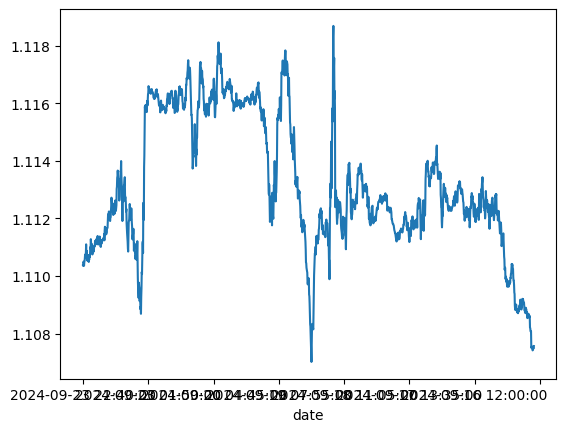

In [9]:
## Revisar serie de tiempo
df['close'].plot(kind='line')


<Axes: xlabel='date'>

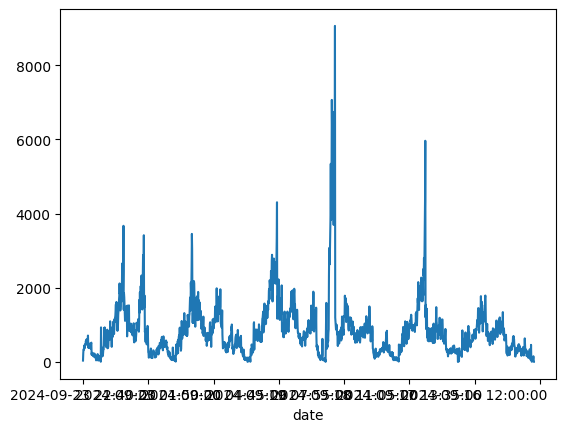

In [10]:
df['volume'].plot(kind='line')

## IQR 

In [11]:
import numpy as np

In [12]:
vol_s = df['volume']

Q1 = np.percentile(vol_s, 25)
Q3 = np.percentile(vol_s, 75)

Qz = np.percentile(vol_s, 95)
IQR = Q3 - Q1

### Objetivo crear un vector de anomalia ascendente

In [13]:
vol_high = df[df['volume'] > Qz]

<Axes: xlabel='date'>

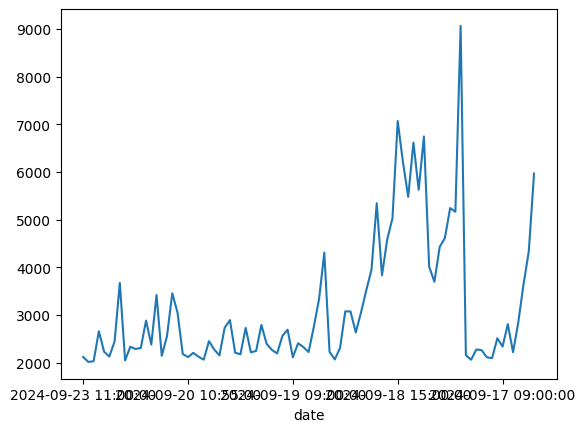

In [14]:
vol_high['volume'].plot(kind='line')

In [15]:
vol_high['volume'].head(60)

date
2024-09-23 11:00:00    2118
2024-09-23 10:35:00    2014
2024-09-23 10:15:00    2028
2024-09-23 10:10:00    2657
2024-09-23 10:05:00    2228
2024-09-23 10:00:00    2127
2024-09-23 09:50:00    2443
2024-09-23 09:45:00    3672
2024-09-23 04:15:00    2046
2024-09-23 04:00:00    2332
2024-09-23 03:50:00    2285
2024-09-23 03:35:00    2306
2024-09-23 03:30:00    2881
2024-09-23 03:20:00    2378
2024-09-23 03:15:00    3418
2024-09-20 12:00:00    2142
2024-09-20 11:45:00    2557
2024-09-20 11:40:00    3454
2024-09-20 11:35:00    3052
2024-09-20 11:00:00    2180
2024-09-20 10:55:00    2115
2024-09-19 10:50:00    2203
2024-09-19 10:45:00    2124
2024-09-19 10:35:00    2061
2024-09-19 10:25:00    2450
2024-09-19 10:20:00    2275
2024-09-19 10:15:00    2151
2024-09-19 10:10:00    2732
2024-09-19 10:05:00    2891
2024-09-19 10:00:00    2208
2024-09-19 09:50:00    2173
2024-09-19 09:45:00    2727
2024-09-19 09:40:00    2214
2024-09-19 09:35:00    2245
2024-09-19 09:30:00    2790
2024-09-19 09:2

## Funciones Finales 

In [16]:
def get_fx_data(ticker, period, starting, ending, API_KEY):
    # Crear la URL dinámica con los parámetros de entrada
    url = f'https://financialmodelingprep.com/api/v3/historical-chart/{period}/{ticker}?from={starting}&to={ending}&apikey={API_KEY}'
    
    # Hacer la solicitud GET a la API
    response = requests.get(url)
    
    # Comprobar si la respuesta fue exitosa (status code 200)
    if response.status_code == 200:
        # Convertir la respuesta a formato JSON
        data = response.json()
        df = pd.DataFrame(data)
        df = df.assign(ticker = f'{ticker}')
        return df
    else:
        # Si hubo un error, devolver el código de error
        print(f"Error: {response.status_code}")
        return None

In [17]:

def get_available_forex_pairs(API_KEY):
    # Crear la URL dinámica con la API Key
    url = f'https://financialmodelingprep.com/api/v3/symbol/available-forex-currency-pairs?apikey={API_KEY}'
    
    # Hacer la solicitud GET a la API
    response = requests.get(url)
    
    # Comprobar si la respuesta fue exitosa (status code 200)
    if response.status_code == 200:
        # Convertir la respuesta a formato JSON
        forex_pairs = response.json()
        df = pd.DataFrame(forex_pairs)
        return df
    else:
        # Si hubo un error, devolver el código de error
        print(f"Error: {response.status_code}")
        return None


In [18]:
test = get_available_forex_pairs(API_KEY)

In [19]:
df = get_fx_data('ARSMXN', '5min', '2024-09-01', '2024-09-22', API_KEY)

In [20]:
df.head()

,date,open,low,high,close,volume,ticker
0,2024-09-22 23:55:00,0.020124,0.020120,0.020129,0.020127,361,ARSMXN
1,2024-09-22 23:50:00,0.020129,0.020120,0.020129,0.020127,342,ARSMXN
2,2024-09-22 23:45:00,0.020129,0.020121,0.020130,0.020128,668,ARSMXN
3,2024-09-22 23:40:00,0.020129,0.020122,0.020129,0.020129,426,ARSMXN
4,2024-09-22 23:35:00,0.020129,0.020118,0.020129,0.020128,494,ARSMXN


In [21]:
#!pip install pykalman

In [22]:
from pykalman import KalmanFilter
import numpy as np

# Obtener los precios de cierre del DataFrame
closing_prices = df['close'].values

# Inicializar el Filtro de Kalman
kf = KalmanFilter(initial_state_mean=closing_prices[0], n_dim_obs=1)

# Aplicar el filtro de Kalman a la serie de precios de cierre
state_means, state_covariances = kf.smooth(closing_prices)

# Agregar la serie suavizada al DataFrame
df['kalman_smoothed'] = state_means

# Mostrar el DataFrame resultante
print(df)

                     date      open       low      high     close  volume  \
0     2024-09-22 23:55:00  0.020124  0.020120  0.020129  0.020127     361   
1     2024-09-22 23:50:00  0.020129  0.020120  0.020129  0.020127     342   
2     2024-09-22 23:45:00  0.020129  0.020121  0.020130  0.020128     668   
3     2024-09-22 23:40:00  0.020129  0.020122  0.020129  0.020129     426   
4     2024-09-22 23:35:00  0.020129  0.020118  0.020129  0.020128     494   
...                   ...       ...       ...       ...       ...     ...   
1684  2024-09-13 00:20:00  0.020318  0.020308  0.020319  0.020316     865   
1685  2024-09-13 00:15:00  0.020318  0.020311  0.020320  0.020319     639   
1686  2024-09-13 00:10:00  0.020317  0.020311  0.020320  0.020320     396   
1687  2024-09-13 00:05:00  0.020318  0.020308  0.020320  0.020318     897   
1688  2024-09-13 00:00:00  0.020317  0.020310  0.020322  0.020318    1057   

      ticker  kalman_smoothed  
0     ARSMXN         0.020127  
1     ARSMX

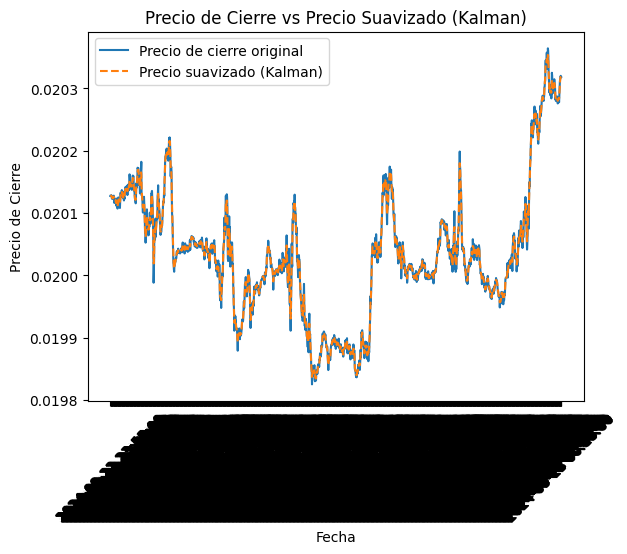

In [24]:
# Graficar los precios originales y los suavizados
plt.plot(df['date'], df['close'], label='Precio de cierre original')
plt.plot(df['date'], df['kalman_smoothed'], label='Precio suavizado (Kalman)', linestyle='--')

# Etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Precio de Cierre vs Precio Suavizado (Kalman)')
plt.legend()
plt.xticks(rotation=45)
plt.show()